Missing values before dropping:
Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64 

Missing values after dropping:
Loan_ID              0
Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
dtype: int64 

    Loan_ID Gender Married Dependents     Education Self_Employed  \
1  LP001003   Male     Yes          1      Graduate            No   
2  LP001005   Male     Yes          0      Graduate           Yes   
3  LP001006   Male     Yes          0  Not Graduate            No   
4  LP001008   Male  

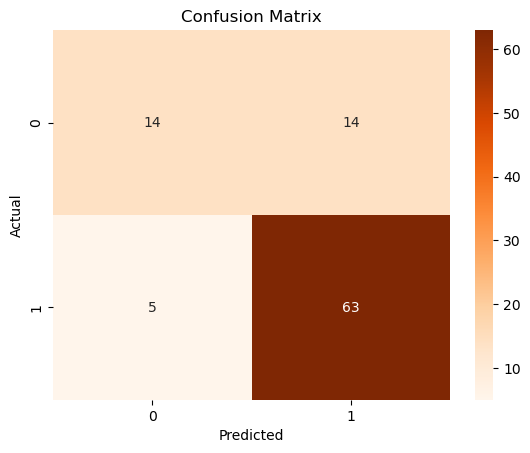

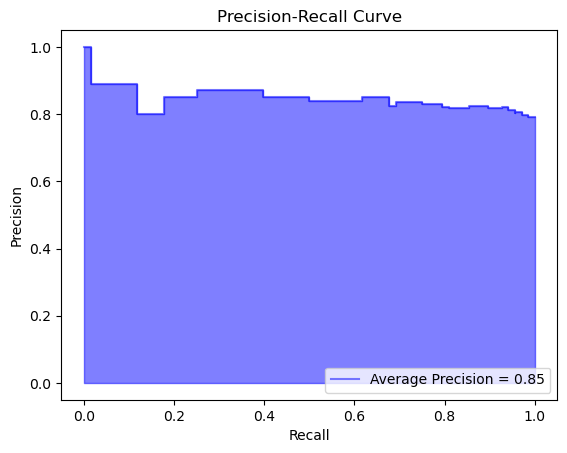

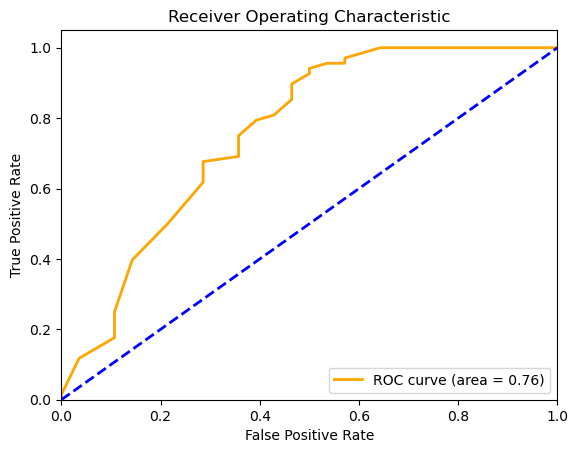

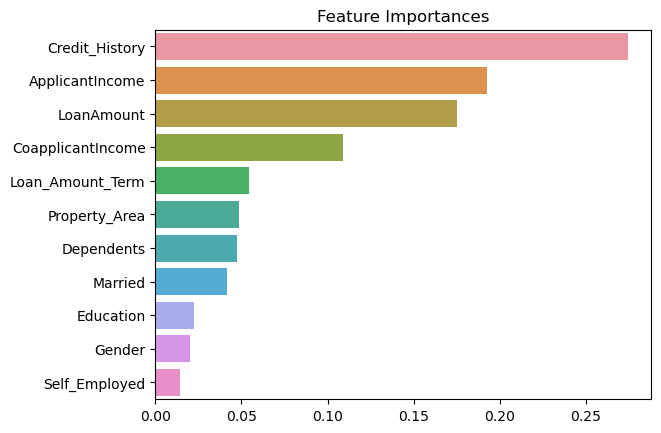

Model saved to trained_model.joblib


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve, average_precision_score, roc_curve, roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import joblib

class ML_model:
    # Assess rows with missing values
    def handle_missing_values(self, df):
        # Count of missing values before dropping
        print("Missing values before dropping:")
        print(df.isna().sum(), "\n")

        # Drop rows with missing values
        df = df.dropna()

        # Count of missing values after dropping
        print("Missing values after dropping:")
        print(df.isna().sum(), "\n")

        return df

    # Load dataset and declare test/train
    def proc_Data(self, df):
        print(df.head())
        
        # Convert labels to a numeric form
        le = LabelEncoder()
        for column in ["Gender", "Married", "Dependents", "Education", "Self_Employed", "Property_Area", "Loan_Status"]:
            df[column] = le.fit_transform(df[column])

        # Declare x and y variables
        y_data = df["Loan_Status"]
        X_data = df.drop(["Loan_Status", "Loan_ID"], axis=1)
        
        print(df.head())
        
        # Get Training and Test sets
        X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.20, random_state=42)
        print(X_train.shape, ": Training data size")
        print(X_test.shape, ": Test data size")
        
        # Balance the training data
        smote = SMOTE(random_state=0)
        X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)
        print(X_train_balanced.shape, ": Balanced training data size")
        
        # Save as objects
        self.X_train = X_train_balanced
        self.X_test = X_test
        self.y_train = y_train_balanced
        self.y_test = y_test

    # Declare the ML model
    def declareML_train(self):
        classifier = RandomForestClassifier(n_estimators=30, bootstrap=True, criterion="entropy", random_state=0)
        classifier.fit(self.X_train, self.y_train)
        self.classifier = classifier
        self.pred_y = classifier.predict(self.X_test)
    
    # Evaluate performance of the trained model
    def evaluate_MLmodel(self):
        # Confusion matrix display
        C_matrix = confusion_matrix(self.y_test, self.pred_y)
        print(classification_report(self.y_test, self.pred_y))
        print(C_matrix)
        
        # Visualized confusion matrix display
        sns.heatmap(C_matrix, annot=True, cmap="Oranges")
        plt.title("Confusion Matrix")
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.show()
        
        # Precision-recall curve display
        precision, recall, _ = precision_recall_curve(self.y_test, self.classifier.predict_proba(self.X_test)[:,1])
        avg_precision = average_precision_score(self.y_test, self.classifier.predict_proba(self.X_test)[:,1])
        
        plt.step(recall, precision, where="post", color="blue", alpha=0.5, label="Average Precision = %0.2f" % avg_precision)
        plt.fill_between(recall, precision, step="post", alpha=0.5, color="b")
        plt.title("Precision-Recall Curve")
        plt.xlabel("Recall")
        plt.ylabel("Precision")
        plt.legend(loc="lower right")
        plt.show()
        
        # ROC curve display
        fpr, tpr, _ = roc_curve(self.y_test, self.classifier.predict_proba(self.X_test)[:,1])
        roc_auc = roc_auc_score(self.y_test, self.classifier.predict_proba(self.X_test)[:,1])
        
        plt.plot(fpr, tpr, color="orange", lw=2, label="ROC curve (area = %0.2f)" % roc_auc)
        plt.plot([0, 1], [0, 1], color="blue", lw=2, linestyle="--")
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.title("Receiver Operating Characteristic")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.legend(loc="lower right")
        plt.show()
        
        # Feature importance display
        feature_importances = pd.Series(self.classifier.feature_importances_, index=self.X_train.columns)
        feature_importances.sort_values(ascending=False, inplace=True)
        
        sns.barplot(x=feature_importances, y=feature_importances.index)
        plt.title("Feature Importances")
        plt.show()

    # Export trained model for future use.
    def save_model(self, file_path):
        joblib.dump(self.classifier, file_path)
        print(f"Model saved to {file_path}")

    def load_model(self, file_path):
        self.classifier = joblib.load(file_path)
        print(f"Model loaded from {file_path}")

# === Main Driver ===

# Load, review, and adjust data
handle = ML_model()
df_train = pd.read_csv("loan_sanction_train.csv")
df_train = handle.handle_missing_values(df_train)

handle.proc_Data(df_train)
handle.declareML_train()
handle.evaluate_MLmodel()

# Save trained model
handle.save_model("trained_model.joblib")